In [7]:
import os
import time
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Most important path (freeze,trained Model)
PATH_TO_CKPT = r"G:\My Drive\Programming\summer-practise-2021\Tensorflow_v1_color_aug_middle\models\research\fine_tuned_model\frozen_inference_graph.pb"

# Label to annotate box in numpy image
PATH_TO_LABELS = r"G:\My Drive\Programming\summer-practise-2021\Tensorflow_v1_color_aug_middle\tensorflow-object-detection-faster-rcnn\data\train\Hole_label_map.pbtxt"

# Sample image address
PATH_TO_TEST_IMAGES_DIR =  r"C:\Users\margo\OneDrive\Dokumenty\GitHub\summer-practise-2021\TensorflowObjectDetectionAPI\test_photos"

In [8]:
#Get absolute path off all items
for root_dir, main, interior in os.walk(os.path.abspath(PATH_TO_TEST_IMAGES_DIR)):
    TEST_IMAGE_PATHS = [os.path.join(root_dir, i) for i in interior]
    

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes= 1, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


# define own output size
USER_DEFINE_PHOTO_SIZE_OUTPUT = (20, 10)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

(50, 290, 3)
--- 3.027395248413086 seconds ---


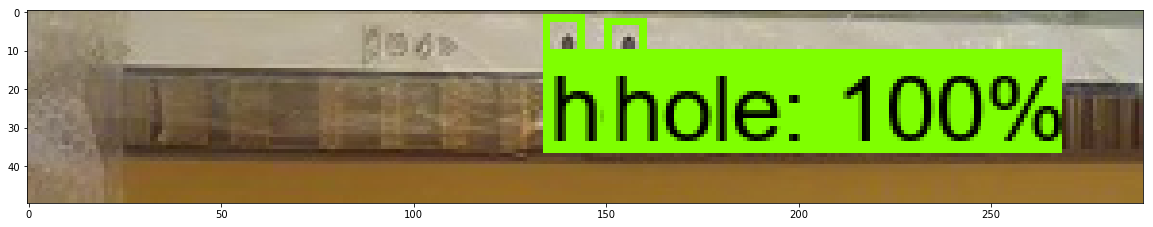

In [10]:
image = Image.open(TEST_IMAGE_PATHS[0])

#Convert Image to numpy format
image_np = np.array(image)
print(image_np.shape)
image_np_expanded = np.expand_dims(image_np, axis=0)

# Measure detection time
start_time = time.time()
output_dict = run_inference_for_single_image(image_np, detection_graph)
print("--- {} seconds ---".format(time.time() - start_time))

# Generate interactive output
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    min_score_thresh=.9,
    line_thickness=2)
plt.figure(figsize=USER_DEFINE_PHOTO_SIZE_OUTPUT)
plt.imshow(image_np)